In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols # linear ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
import statsmodels.formula.api as smf

##### Data loading

The educational level is 'isced1997_r' in wave 2

In [ ]:
maxchair = pd.read_csv("maxchair.csv")
maxchair.shape

(9753, 11)

In [24]:
maxchair

,mergeid,age,bmi,female,educational_level,OA_conserv,Hypertension,Diabetes,maxgrip,chair,disease_category
0,AT-004234-02,53.0,30.717400,1.0,1.0,0.0,0.0,1.0,37.0,6.00,Only Diabetes
1,AT-016392-01,61.0,23.588329,1.0,1.0,0.0,0.0,0.0,34.0,13.20,No disease
2,AT-017298-01,64.0,25.381469,0.0,2.0,0.0,1.0,0.0,55.0,9.40,Only HT
3,AT-026212-02,59.0,24.337480,0.0,1.0,0.0,0.0,0.0,52.0,22.00,No disease
4,AT-177589-02,57.0,40.057345,1.0,0.0,0.0,1.0,1.0,36.0,8.32,HT and Diab
...,...,...,...,...,...,...,...,...,...,...,...
9748,SE-985630-02,63.0,21.107266,1.0,1.0,0.0,0.0,0.0,25.0,7.94,No disease
9749,SE-994435-01,54.0,25.484765,0.0,1.0,0.0,0.0,0.0,61.0,7.41,No disease
9750,SE-996850-01,61.0,26.827421,0.0,1.0,0.0,0.0,0.0,61.0,7.03,No disease
9751,SE-996850-02,61.0,23.323418,1.0,1.0,0.0,1.0,0.0,32.0,13.94,Only HT


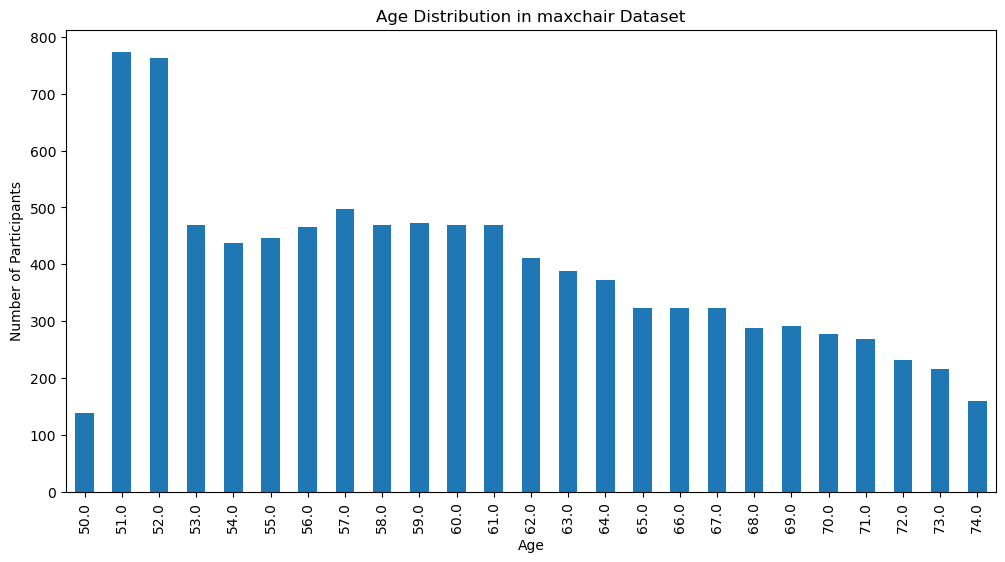

In [25]:
age_counts = maxchair['age'].value_counts().sort_index()
plt.figure(figsize=(12,6))
age_counts.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Number of Participants')
plt.title('Age Distribution in maxchair Dataset')
plt.show()

In [26]:
age_counts_all = maxchair['age'].value_counts().sort_index()
print(age_counts_all)

age
50.0    139
51.0    774
52.0    763
53.0    470
54.0    438
55.0    447
56.0    466
57.0    498
58.0    469
59.0    473
60.0    469
61.0    469
62.0    411
63.0    388
64.0    373
65.0    324
66.0    324
67.0    324
68.0    288
69.0    291
70.0    278
71.0    269
72.0    232
73.0    216
74.0    160
Name: count, dtype: int64


## statistical

##### Statistics on df_features

- **0**: No disease  
- **1**:  
  - Diabetes only  
  - Hypertension only  
  - OA only  
- **2**:  
  - Diabetes + Hypertension  
  - Diabetes + OA  
  - Hypertension + OA  
- **3**: Diabetes + Hypertension + OA 


In [27]:
maxchair['disease_category'] = 'No disease'  # Default group
maxchair.loc[(maxchair['OA_conserv'] == 1) & (maxchair['Hypertension'] == 0) & (maxchair['Diabetes'] == 0), 'disease_category'] = 'Only OA'
maxchair.loc[(maxchair['OA_conserv'] == 0) & (maxchair['Hypertension'] == 1) & (maxchair['Diabetes'] == 0), 'disease_category'] = 'Only HT'
maxchair.loc[(maxchair['OA_conserv'] == 0) & (maxchair['Hypertension'] == 0) & (maxchair['Diabetes'] == 1), 'disease_category'] = 'Only Diabetes'
maxchair.loc[(maxchair['OA_conserv'] == 1) & (maxchair['Hypertension'] == 1) & (maxchair['Diabetes'] == 0), 'disease_category'] = 'OA and HT'
maxchair.loc[(maxchair['OA_conserv'] == 1) & (maxchair['Hypertension'] == 0) & (maxchair['Diabetes'] == 1), 'disease_category'] = 'OA and Diab'
maxchair.loc[(maxchair['OA_conserv'] == 0) & (maxchair['Hypertension'] == 1) & (maxchair['Diabetes'] == 1), 'disease_category'] = 'HT and Diab'
maxchair.loc[(maxchair['OA_conserv'] == 1) & (maxchair['Hypertension'] == 1) & (maxchair['Diabetes'] == 1), 'disease_category'] = 'All three diseases'


### Maxgrip

#### No confounding

##### Step1: One-Way ANOVA

Checks if any group differs

In [28]:
groups = maxchair['disease_category'].unique()
grip_samples = [maxchair[maxchair['disease_category'] == group]['maxgrip'].dropna() for group in groups]

# Run ANOVA
anova_grip = f_oneway(*grip_samples)
print("ANOVA for Grip Strength")
print(f"F-statistic: {anova_grip.statistic:.3f}, p-value: {anova_grip.pvalue:.5f}")


ANOVA for Grip Strength
F-statistic: 31.505, p-value: 0.00000


##### Step2: Tukey HSD Post-hoc Comparison

Identifies which groups differ

In [29]:
df_grip = maxchair[['maxgrip', 'disease_category']].dropna()

# Run Tukey HSD
tukey_grip = pairwise_tukeyhsd(endog=df_grip['maxgrip'],
                               groups=df_grip['disease_category'],
                               alpha=0.05)

print("Turkey Maxgrip in age under 75")
print(tukey_grip.summary())


Turkey Maxgrip in age under 75
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1           group2    meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------
All three diseases   HT and Diab   4.8051   0.01  0.6761  8.9341   True
All three diseases    No disease   6.5213    0.0  2.7745 10.2681   True
All three diseases   OA and Diab   1.5591 0.9937 -4.4357  7.5539  False
All three diseases     OA and HT   1.0171 0.9949 -3.0202  5.0543  False
All three diseases Only Diabetes   6.3894 0.0001  2.1431 10.6356   True
All three diseases       Only HT   6.0206    0.0  2.2267  9.8144   True
All three diseases       Only OA    1.901 0.8278 -2.0414  5.8434  False
       HT and Diab    No disease   1.7162 0.0941 -0.1394  3.5717  False
       HT and Diab   OA and Diab   -3.246 0.5129   -8.28   1.788  False
       HT and Diab     OA and HT   -3.788    0.0 -6.1762 -1.3998   True
       HT and Diab Only Diabetes 

##### Number of samples in each group

In [30]:
group_counts = maxchair[maxchair['maxgrip'].notna()].groupby('disease_category').size()
print(group_counts)

disease_category
All three diseases      88
HT and Diab            377
No disease            5617
OA and Diab             55
OA and HT              491
Only Diabetes          289
Only HT               2129
Only OA                707
dtype: int64


##### Step3: Code to Compute Cohen's d and 95% CI

In [31]:
comparisons = [
    ("No disease", "Only OA"),
    ("No disease", "Only HT"),
    ("No disease", "Only Diabetes"),
    ("No disease", "HT and Diab"),
    ("No disease", "OA and Diab"),
    ("No disease", "OA and HT"),
    ("No disease", "All three diseases")
]

results = []

for g1, g2 in comparisons:

    group1 = maxchair[(maxchair['disease_category'] == g1)]['maxgrip'].dropna()
    group2 = maxchair[(maxchair['disease_category'] == g2)]['maxgrip'].dropna()

    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    n1, n2 = len(group1), len(group2)

    pooled_sd = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))

    cohen_d = (mean1 - mean2) / pooled_sd

    diff = mean1 - mean2
    se_diff = np.sqrt(std1**2 / n1 + std2**2 / n2)
    ci_low, ci_high = diff - 1.96 * se_diff, diff + 1.96 * se_diff

    results.append({
        'Comparison': f"{g1} vs {g2}",
        'Mean1': round(mean1, 2),
        'Mean2': round(mean2, 2),
        'Cohen_d': round(cohen_d, 3),
        '95% CI Lower': round(ci_low, 3),
        '95% CI Upper': round(ci_high, 3),
        'n1': n1,
        'n2': n2
    })


effect_df = pd.DataFrame(results)
effect_df


,Comparison,Mean1,Mean2,Cohen_d,95% CI Lower,95% CI Upper,n1,n2
0,No disease vs Only OA,38.18,33.56,0.402,3.714,5.526,5617,707
1,No disease vs Only HT,38.18,37.68,0.043,-0.079,1.080,5617,2129
2,No disease vs Only Diabetes,38.18,38.05,0.012,-1.160,1.424,5617,289
3,No disease vs HT and Diab,38.18,36.46,0.149,0.527,2.906,5617,377
4,No disease vs OA and Diab,38.18,33.22,0.432,1.838,8.087,5617,55
5,No disease vs OA and HT,38.18,32.68,0.480,4.467,6.541,5617,491
6,No disease vs All three diseases,38.18,31.66,0.568,4.091,8.951,5617,88


#### With confounding: age, BMI, female, educational_level:

Run OLS model (adjusted for age, bmi, female)

In [32]:
# Set 'No disease' as reference group 
maxchair['disease_category'] = pd.Categorical(
    maxchair['disease_category'],
    categories=[
        'No disease', 'Only OA', 'Only HT', 'Only Diabetes',
        'HT and Diab', 'OA and Diab', 'OA and HT', 'All three diseases'
    ],
    ordered=False
)

model = smf.ols('maxgrip ~ C(disease_category) + age + bmi + female + educational_level', data=maxchair).fit()

results_df = pd.DataFrame({
    'Disease group': model.params.index,
    'Coefficient (Adj. Mean Diff)': model.params.values,
    '95% CI Lower': model.conf_int().iloc[:, 0],
    '95% CI Upper': model.conf_int().iloc[:, 1],
    'p-value': model.pvalues.values
})

results_df = results_df[results_df['Disease group'].str.contains('C\(disease_category\)')].copy()

results_df['Disease group'] = results_df['Disease group'].str.replace(r'C\(disease_category\)\[T\.', '', regex=True).str.rstrip(']')

results_df['Coefficient (Adj. Mean Diff)'] = results_df['Coefficient (Adj. Mean Diff)'].round(3)
results_df['95% CI Lower'] = results_df['95% CI Lower'].round(3)
results_df['95% CI Upper'] = results_df['95% CI Upper'].round(3)
results_df['p-value'] = results_df['p-value'].round(4)
results_df['Significant'] = results_df['p-value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

print("OLS results for maxgrip in age under 75 (No disease as reference):")
results_df.reset_index(drop=True)


OLS results for maxgrip in age under 75 (No disease as reference):


,Disease group,Coefficient (Adj. Mean Diff),95% CI Lower,95% CI Upper,p-value,Significant
0,Only OA,-1.509,-2.076,-0.941,0.0000,Yes
1,Only HT,0.094,-0.276,0.465,0.6177,No
2,Only Diabetes,-1.799,-2.659,-0.938,0.0000,Yes
3,HT and Diab,-1.243,-2.013,-0.473,0.0016,Yes
4,OA and Diab,-2.852,-4.774,-0.930,0.0036,Yes
5,OA and HT,-2.065,-2.744,-1.386,0.0000,Yes
6,All three diseases,-3.128,-4.668,-1.588,0.0001,Yes


##### Interaction Effects: Does OA Get Worse With Comorbidities?

In [33]:
maxchair['disease_category'] = pd.Categorical(
    maxchair['disease_category'],
    categories=[
        'No disease',            
        'Only OA',
        'Only HT',
        'Only Diabetes',
        'OA and HT',
        'OA and Diab',
        'HT and Diab',
        'All three diseases'
    ],
    ordered=False
)


In [34]:
model = smf.ols('maxgrip ~ C(disease_category) + age + bmi + female + educational_level + C(OA_conserv)*C(Diabetes) + C(OA_conserv)*C(Hypertension)', 
                data=maxchair).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                maxgrip   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     1413.
Date:                Tue, 22 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:09:30   Log-Likelihood:                -33116.
No. Observations:                9753   AIC:                         6.626e+04
Df Residuals:                    9741   BIC:                         6.634e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

##### Logistic Regression: Predicting "High Risk" Patients

In [35]:
maxchair['low_grip'] = (maxchair['maxgrip'] < maxchair['maxgrip'].quantile(0.25)).astype(int)

X = maxchair[['age', 'bmi', 'female', 'educational_level','OA_conserv', 'Diabetes', 'Hypertension']]
y = maxchair['low_grip']

logit_model = sm.Logit(y, sm.add_constant(X)).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.378246
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               low_grip   No. Observations:                 9753
Model:                          Logit   Df Residuals:                     9745
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                  0.2759
Time:                        10:09:31   Log-Likelihood:                -3689.0
converged:                       True   LL-Null:                       -5094.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -8.1850      0.349    -23.428      0.000      -8.870      -7.500
age     

### Chair

#### No confounding

##### Step1: One-Way ANOVA

Checks if any group differs

In [36]:
# ANOVA for Chair Stand
chair_samples = [maxchair[maxchair['disease_category'] == group]['chair'].dropna() for group in groups]

anova_chair = f_oneway(*chair_samples)
print("\nANOVA for Chair Stand")
print(f"F-statistic: {anova_chair.statistic:.3f}, p-value: {anova_chair.pvalue:.5f}")



ANOVA for Chair Stand
F-statistic: 8.423, p-value: 0.00000


##### Step2: Tukey HSD Post-hoc Comparison

Identifies which groups differ

In [37]:
# Tukey HSD for Chair Stand
df_chair = maxchair[['chair', 'disease_category']].dropna()

tukey_chair = pairwise_tukeyhsd(endog=df_chair['chair'],
                                groups=df_chair['disease_category'],
                                alpha=0.05)

print("Turkey Chair Stand in age under 75")
print(tukey_chair.summary())


Turkey Chair Stand in age under 75
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1           group2    meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------
All three diseases   HT and Diab    0.042    1.0 -2.4289  2.5129  False
All three diseases    No disease  -1.8235 0.2105 -4.0658  0.4187  False
All three diseases   OA and Diab    0.632 0.9995 -2.9555  4.2195  False
All three diseases     OA and HT  -0.7265 0.9851 -3.1425  1.6896  False
All three diseases Only Diabetes  -1.7637 0.4122 -4.3048  0.7775  False
All three diseases       Only HT  -1.5491 0.4357 -3.8195  0.7213  False
All three diseases       Only OA   -0.621 0.9933 -2.9803  1.7383  False
       HT and Diab    No disease  -1.8655    0.0 -2.9759 -0.7551   True
       HT and Diab   OA and Diab     0.59  0.999 -2.4226  3.6026  False
       HT and Diab     OA and HT  -0.7685 0.7321 -2.1977  0.6607  False
       HT and Diab Only Diabe

##### Number of samples in each group

In [38]:
group_counts = maxchair[maxchair['chair'].notna()].groupby('disease_category').size()
print(group_counts)

disease_category
No disease            5617
Only OA                707
Only HT               2129
Only Diabetes          289
OA and HT              491
OA and Diab             55
HT and Diab            377
All three diseases      88
dtype: int64


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_65339/3200676261.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = maxchair[maxchair['chair'].notna()].groupby('disease_category').size()


##### Step3: Compute Cohen's d and 95% CI

In [39]:
comparisons = [
    ("No disease", "Only OA"),
    ("No disease", "Only HT"),
    ("No disease", "Only Diabetes"),
    ("No disease", "HT and Diab"),
    ("No disease", "OA and Diab"),
    ("No disease", "OA and HT"),
    ("No disease", "All three diseases")
]

results = []

for g1, g2 in comparisons:
   
    group1 = maxchair[(maxchair['disease_category'] == g1)]['chair'].dropna()
    group2 = maxchair[(maxchair['disease_category'] == g2)]['chair'].dropna()

    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    n1, n2 = len(group1), len(group2)

    pooled_sd = np.sqrt(((n1 - 1)*std1**2 + (n2 - 1)*std2**2) / (n1 + n2 - 2))

    cohen_d = (mean1 - mean2) / pooled_sd

    diff = mean1 - mean2
    se_diff = np.sqrt(std1**2 / n1 + std2**2 / n2)
    ci_low, ci_high = diff - 1.96 * se_diff, diff + 1.96 * se_diff

    results.append({
        'Comparison': f"{g1} vs {g2}",
        'Mean1': round(mean1, 2),
        'Mean2': round(mean2, 2),
        'Cohen_d': round(cohen_d, 3),
        '95% CI Lower': round(ci_low, 3),
        '95% CI Upper': round(ci_high, 3),
        'n1': n1,
        'n2': n2
    })

effect_df = pd.DataFrame(results)
effect_df

,Comparison,Mean1,Mean2,Cohen_d,95% CI Lower,95% CI Upper,n1,n2
0,No disease vs Only OA,10.86,12.06,-0.168,-1.718,-0.687,5617,707
1,No disease vs Only HT,10.86,11.14,-0.040,-0.593,0.044,5617,2129
2,No disease vs Only Diabetes,10.86,10.92,-0.008,-0.716,0.597,5617,289
3,No disease vs HT and Diab,10.86,12.73,-0.252,-2.838,-0.893,5617,377
4,No disease vs OA and Diab,10.86,13.32,-0.339,-4.271,-0.640,5617,55
5,No disease vs OA and HT,10.86,11.96,-0.155,-1.580,-0.614,5617,491
6,No disease vs All three diseases,10.86,12.68,-0.252,-2.994,-0.653,5617,88


#### With confounding: age, BMI, female, educational_level:

Run OLS model (adjusted for age, bmi, female)

In [40]:
maxchair['disease_category'] = pd.Categorical(
    maxchair['disease_category'],
    categories=[
        'No disease', 'Only OA', 'Only HT', 'Only Diabetes',
        'HT and Diab', 'OA and Diab', 'OA and HT', 'All three diseases'
    ],
    ordered=False
)

model = smf.ols('chair ~ C(disease_category) + age + bmi + female + educational_level', data=maxchair).fit()


results_df = pd.DataFrame({
    'Disease group': model.params.index,
    'Coefficient (Adj. Mean Diff)': model.params.values,
    '95% CI Lower': model.conf_int().iloc[:, 0],
    '95% CI Upper': model.conf_int().iloc[:, 1],
    'p-value': model.pvalues.values
})

results_df = results_df[results_df['Disease group'].str.contains('C\(disease_category\)')].copy()

results_df['Disease group'] = results_df['Disease group'].str.replace(r'C\(disease_category\)\[T\.', '', regex=True).str.rstrip(']')


results_df['Coefficient (Adj. Mean Diff)'] = results_df['Coefficient (Adj. Mean Diff)'].round(3)
results_df['95% CI Lower'] = results_df['95% CI Lower'].round(3)
results_df['95% CI Upper'] = results_df['95% CI Upper'].round(3)
results_df['p-value'] = results_df['p-value'].round(4)
results_df['Significant'] = results_df['p-value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

print("OLS results for chair in age under 75 (No disease as reference):")
results_df.reset_index(drop=True)


OLS results for chair in age under 75 (No disease as reference):


,Disease group,Coefficient (Adj. Mean Diff),95% CI Lower,95% CI Upper,p-value,Significant
0,Only OA,0.825,0.289,1.361,0.0025,Yes
1,Only HT,-0.133,-0.483,0.217,0.4553,No
2,Only Diabetes,-0.288,-1.100,0.524,0.4870,No
3,HT and Diab,1.170,0.443,1.897,0.0016,Yes
4,OA and Diab,1.799,-0.015,3.613,0.0519,No
5,OA and HT,0.302,-0.339,0.942,0.3559,No
6,All three diseases,0.766,-0.686,2.219,0.3011,No


In [41]:
group_counts = maxchair[maxchair['chair'].notna()].groupby('disease_category').size()
print(group_counts)

disease_category
No disease            5617
Only OA                707
Only HT               2129
Only Diabetes          289
HT and Diab            377
OA and Diab             55
OA and HT              491
All three diseases      88
dtype: int64


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_65339/3200676261.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = maxchair[maxchair['chair'].notna()].groupby('disease_category').size()


##### Interaction Effects: Does OA Get Worse With Comorbidities?

In [42]:
maxchair['disease_category'] = pd.Categorical(
    maxchair['disease_category'],
    categories=[
        'No disease',         
        'Only OA',
        'Only HT',
        'Only Diabetes',
        'OA and HT',
        'OA and Diab',
        'HT and Diab',
        'All three diseases'
    ],
    ordered=False
)

In [43]:
model = smf.ols('chair ~ C(disease_category) + age + bmi + female + educational_level + C(OA_conserv)*C(Diabetes) + C(OA_conserv)*C(Hypertension)', 
                data=maxchair).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  chair   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     24.36
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           2.54e-50
Time:                        10:09:32   Log-Likelihood:                -32548.
No. Observations:                9753   AIC:                         6.512e+04
Df Residuals:                    9741   BIC:                         6.521e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

##### Logistic Regression: Predicting "High Risk" Patients

In [44]:
maxchair['low_grip'] = (maxchair['chair'] < maxchair['chair'].quantile(0.25)).astype(int)

X = maxchair[['age', 'bmi', 'female', 'educational_level','OA_conserv', 'Diabetes', 'Hypertension']]
y = maxchair['low_grip']

logit_model = sm.Logit(y, sm.add_constant(X)).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.543316
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               low_grip   No. Observations:                 9753
Model:                          Logit   Df Residuals:                     9745
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Jul 2025   Pseudo R-squ.:                 0.03339
Time:                        10:09:32   Log-Likelihood:                -5299.0
converged:                       True   LL-Null:                       -5482.0
Covariance Type:            nonrobust   LLR p-value:                 4.537e-75
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4414      0.280      8.724      0.000       1.893       2.990
age     

## Summery table (Table 1 in paper)

In [45]:
groups = [
    'No disease', 'Only OA', 'Only HT', 'Only Diabetes',
    'OA and Diab', 'OA and HT', 'HT and Diab', 'All three diseases'
]

maxchair = maxchair[maxchair['disease_category'].isin(groups)].copy()


summary = {}

for group in groups:
    sub = maxchair[maxchair['disease_category'] == group]
    

    n = len(sub)
    percent = 100 * n / len(maxchair)

    age_mean = sub['age'].mean()
    age_sd = sub['age'].std()
    age_min = sub['age'].min()
    age_max = sub['age'].max()

    female_n = sub['female'].sum()
    female_percent = 100 * female_n / n if n > 0 else 0
        
    bmi_mean = sub['bmi'].mean()
    bmi_sd = sub['bmi'].std()
    

    edu_counts = sub['educational_level'].value_counts(dropna=False)
    edu_percents = sub['educational_level'].value_counts(normalize=True, dropna=False) * 100
    
    edu_low = edu_counts.get(0, 0)
    edu_medium = edu_counts.get(1, 0)
    edu_high = edu_counts.get(2, 0)
    edu_other = edu_counts.get(3, 0)
    
    edu_low_pct = edu_percents.get(0, 0)
    edu_medium_pct = edu_percents.get(1, 0)
    edu_high_pct = edu_percents.get(2, 0)
    edu_other_pct = edu_percents.get(3, 0)
    
   
    grip_mean = sub['maxgrip'].mean()
    grip_sd = sub['maxgrip'].std()
    
   
    chair_mean = sub['chair'].mean()
    chair_sd = sub['chair'].std()
    
   
    summary[group] = [
        f"{n} ({percent:.2f}%)",
        f"{age_mean:.1f} ± {age_sd:.1f} ({age_min}-{age_max})",  
        f"{female_n} ({female_percent:.1f}%)",
        f"{bmi_mean:.1f} ± {bmi_sd:.1f}",
        f"{edu_low} ({edu_low_pct:.1f}%)",
        f"{edu_medium} ({edu_medium_pct:.1f}%)",
        f"{edu_high} ({edu_high_pct:.1f}%)",
        f"{edu_other} ({edu_other_pct:.1f}%)",
        f"{grip_mean:.1f} ± {grip_sd:.1f}",
        f"{chair_mean:.1f} ± {chair_sd:.1f}"
    ]
variables = [
    "Number of cases",
    "Age; mean (SD) (min-max):",
    "Female; n, (%)",
    "BMI; mean (SD)",
    "Educational Level Low (%)",
    "Educational Level Medium (%)",
    "Educational Level High (%)",
    "Educational Level Other (%)",
    "maxgrip (kg); mean (SD)",
    "chair; mean (SD)"
]

summary_df = pd.DataFrame(summary, index=variables)

summary_df


,No disease,Only OA,Only HT,Only Diabetes,OA and Diab,OA and HT,HT and Diab,All three diseases
Number of cases,5617 (57.59%),707 (7.25%),2129 (21.83%),289 (2.96%),55 (0.56%),491 (5.03%),377 (3.87%),88 (0.90%)
Age; mean (SD) (min-max):,58.9 ± 6.5 (50.0-74.0),60.3 ± 6.6 (50.0-74.0),61.5 ± 6.7 (50.0-74.0),62.2 ± 6.5 (50.0-74.0),61.5 ± 6.7 (51.0-73.0),62.9 ± 6.6 (50.0-74.0),63.3 ± 6.3 (51.0-74.0),63.5 ± 6.9 (50.0-74.0)
"Female; n, (%)",2892.0 (51.5%),470.0 (66.5%),1083.0 (50.9%),105.0 (36.3%),33.0 (60.0%),316.0 (64.4%),180.0 (47.7%),58.0 (65.9%)
BMI; mean (SD),25.9 ± 4.0,26.2 ± 4.0,27.9 ± 5.3,27.9 ± 4.5,28.9 ± 5.0,28.4 ± 4.5,29.8 ± 4.7,32.3 ± 5.1
Educational Level Low (%),1898 (33.8%),294 (41.6%),797 (37.4%),129 (44.6%),30 (54.5%),226 (46.0%),154 (40.8%),41 (46.6%)
Educational Level Medium (%),2240 (39.9%),260 (36.8%),832 (39.1%),103 (35.6%),14 (25.5%),180 (36.7%),149 (39.5%),28 (31.8%)
Educational Level High (%),1373 (24.4%),124 (17.5%),454 (21.3%),47 (16.3%),10 (18.2%),69 (14.1%),64 (17.0%),12 (13.6%)
Educational Level Other (%),106 (1.9%),29 (4.1%),46 (2.2%),10 (3.5%),1 (1.8%),16 (3.3%),10 (2.7%),7 (8.0%)
maxgrip (kg); mean (SD),38.2 ± 11.5,33.6 ± 11.6,37.7 ± 11.7,38.0 ± 10.9,33.2 ± 11.8,32.7 ± 11.2,36.5 ± 11.4,31.7 ± 11.5
chair; mean (SD),10.9 ± 7.2,12.1 ± 6.5,11.1 ± 6.0,10.9 ± 5.5,13.3 ± 6.8,12.0 ± 5.0,12.7 ± 9.4,12.7 ± 5.5
